# **EEG Epoch Processing Framework** 


This project provides a versatile framework for processing EEG data. The primary objective is to preprocess raw EEG recordings, segment them into meaningful "epochs" (time-locked to specific events), and save them for further analysis.  

#### **Key Features and Workflow**:  

1. **Data Loading**: Supports raw EEG data stored in widely-used formats, such as `.edf`.  
2. **Preprocessing**:  
   - **Band-pass Filtering**: Removes frequencies outside the range of interest (e.g., 1–250 Hz).  
   - **Notch Filtering**: Eliminates powerline noise (e.g., at 50/60 Hz and harmonics).  
   - **Wavelet Denoising (optional)**: Reduces noise while preserving important signal features.  
3. **Event Extraction**: Detects experiment-specific triggers in the data (e.g., stimulus presentations or button presses) and maps them to defined events.  
4. **Epoch Creation**: Segments continuous EEG data into smaller time windows (epochs), aligned to the timing of specific events (e.g., stimulus onsets).  
5. **Saving Epochs**: Processed epochs are saved in `.fif` files, ready for further analysis.  

#### **How to Use the Framework**:  
1. **Configuration**: Customize preprocessing parameters like filtering ranges and wavelet options by modifying the `CONFIG` dictionary.  
2. **Running the Pipeline**: Use `main(CONFIG)` to process data for all specified subjects and sessions.  
3. **Loading Processed Data**: The `load_epochs()` function allows easy access to saved epochs for analysis.  

#### **Applications**:  
This framework is designed for flexibility and can be applied to **any EEG dataset**. Whether you're analyzing intracranial EEG (iEEG) or non-invasive scalp EEG, it is ideal for studies requiring precise event-related segmentation, such as:  
- Cognitive neuroscience experiments.  
- Brain-computer interface research.  
- Clinical studies involving event-related potentials (ERPs) or oscillatory activity.  

With this framework, researchers can efficiently prepare EEG data for advanced analysis in just a few steps.  

---


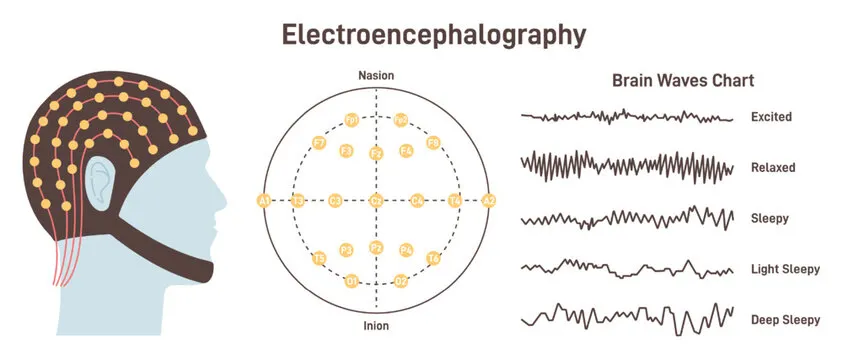

## **Importing Libraries**

In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import mne
from mne.io import Raw
from mne import Epochs, find_events, pick_types
from mne.filter import filter_data


# Set log-level to reduce verbosity
mne.set_log_level("WARNING")

## **Configuration Setup**
Define parameters for preprocessing, including filtering ranges, epoch window, and saving options.

In [8]:

CONFIG = {
    "num_subjects": 40,  # Number of subjects to process (set None for all)
    "apply_wavelet": None,  # Whether to apply wavelet denoising
    "tmin": -0.2,  # Start time for epochs
    "tmax": 0.5,  # End time for epochs
    "l_freq": 1.0,  # Lower bound for band-pass filter
    "h_freq": 250.0,  # Upper bound for band-pass filter
    "notch_filter": True,  # Apply notch filter for powerline noise
    "notch_freqs": 60,  # Base frequency for notch filtering (e.g., 60 Hz)
    "wavelet_params": {  # Wavelet denoising parameters
        "wavelet": "db4",
        "level": 2,
    },
    "save_dir": "processed_epochs",  # Directory to save processed epochs
}

base_dir = "ds005545-download"

## **Functions**

Process each subject's data: apply filtering, extract events, create epochs, and optionally apply wavelet denoising. 

In [9]:
# Wavelet Denoising Function
def wavelet_denoising(data, wavelet="db4", level=2):
    denoised_data = []
    for epoch in data:
        denoised_epoch = []
        for ch_data in epoch:
            coeffs = pywt.wavedec(ch_data, wavelet, level=level)
            thresholded_coeffs = [pywt.threshold(c, np.std(c) * 0.5, mode="soft") for c in coeffs]
            denoised_epoch.append(pywt.waverec(thresholded_coeffs, wavelet))
        denoised_data.append(np.array(denoised_epoch))
    return np.array(denoised_data)


# Main Preprocessing Pipeline
def preprocess_subject(subject_path, config):
    print(f"Processing subject: {subject_path.name}")

    for session in sorted(subject_path.glob("ses-*/ieeg")):
        edf_files = list(session.glob("*.edf"))
        for edf_file in edf_files:
            print(f"Loading iEEG data: {edf_file}")
            raw = mne.io.read_raw_edf(edf_file, preload=True)

            # Apply band-pass filtering
            if config["l_freq"] or config["h_freq"]:
                print(f"Applying band-pass filter: {config['l_freq']}–{config['h_freq']} Hz")
                raw.filter(config["l_freq"], config["h_freq"], fir_design="firwin")

            # Apply notch filter
            if config["notch_filter"]:
                nyquist_freq = raw.info["sfreq"] / 2
                notch_freqs = np.arange(config["notch_freqs"], nyquist_freq, config["notch_freqs"])
                print(f"Applying notch filter at {notch_freqs} Hz")
                raw.notch_filter(freqs=notch_freqs, picks="eeg", filter_length="auto")
                print(f"Sampling frequency: {raw.info['sfreq']} Hz")

            # Extract events
            events, event_id = mne.events_from_annotations(raw)
            print(f"Number of events extracted: {len(events)}")
            print(f"Event mapping: {event_id}")

            # Handle duplicate event times
            try:
                epochs = mne.Epochs(
                    raw,
                    events,
                    event_id,
                    tmin=config["tmin"],
                    tmax=config["tmax"],
                    baseline=(None, 0),
                    preload=True,
                    event_repeated="merge",
                )
                print(f"Number of epochs created: {len(epochs)}")
                print(f"Epochs shape: {epochs.get_data().shape}")
            except RuntimeError as e:
                print(f"Error creating epochs: {e}")
                continue

            # Optional: Wavelet denoising
            if config["apply_wavelet"]:
                print("Applying wavelet denoising...")
                data = epochs.get_data()  # Get NumPy array
                denoised_data = wavelet_denoising(
                    data, wavelet=config["wavelet_params"]["wavelet"], level=config["wavelet_params"]["level"]
                )
            else:
                denoised_data = epochs.get_data()

            # Save preprocessed epochs
            output_dir = Path(config["save_dir"]) / subject_path.name
            output_dir.mkdir(parents=True, exist_ok=True)
            output_file = output_dir / f"{edf_file.stem}_processed-epo.fif"
            epochs.save(output_file, overwrite=True)
            print(f"Saved preprocessed epochs to {output_file}")

            # Verify saved epochs
            loaded_epochs = mne.read_epochs(output_file, preload=True)
            print(f"Reloaded epochs: {loaded_epochs}")


# Execution Script
def main(config):
    base_path = Path(base_dir)  # Replace with your dataset directory

    # Get subjects and limit to the configured number
    subjects = sorted(base_path.glob("sub-*"))
    if config["num_subjects"]:
        subjects = subjects[: config["num_subjects"]]

    print(f"Processing {len(subjects)} subjects...")
    for subject in subjects:
        preprocess_subject(subject, config)



## **Execution Script**

Run the preprocessing and epoch creation pipeline for all subjects in the dataset.

In [10]:
main(CONFIG)


Processing 40 subjects...
Processing subject: sub-01
Loading iEEG data: ds005545-download\sub-01\ses-01\ieeg\sub-01_ses-01_task-auditory_run-01_ieeg.edf
Applying band-pass filter: 1.0–250.0 Hz
Applying notch filter at [ 60. 120. 180. 240. 300. 360. 420. 480.] Hz
Sampling frequency: 1000.0 Hz
Number of events extracted: 183
Event mapping: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}
Number of epochs created: 183
Epochs shape: (183, 66, 701)
Saved preprocessed epochs to processed_epochs\sub-01\sub-01_ses-01_task-auditory_run-01_ieeg_processed-epo.fif
Reloaded epochs: <EpochsFIF | 183 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~64.7 MiB, data loaded,
 'Trigger-401': 61
 'Trigger-402': 61
 'Trigger-501': 61>
Loading iEEG data: ds005545-download\sub-01\ses-02\ieeg\sub-01_ses-02_task-auditory_run-01_ieeg.edf
Applying band-pass filter: 1.0–250.0 Hz
Applying notch filter at [ 60. 120. 180. 240. 300. 360. 420. 480.] Hz
Sampling frequency: 1000.0 Hz
Number of events extract

## **Loading Processed Epochs**
Load saved epochs for specific subjects to prepare for analysis.

In [11]:
# Directory where preprocessed `.fif` files are stored
SAVE_DIR = "processed_epochs"  # Update to your save directory

def load_epochs(subject_id, save_dir=SAVE_DIR):
    """
    Load all `.fif` files for a specific subject.

    Parameters:
    - subject_id: The subject identifier (e.g., 'sub-01').
    - save_dir: The base directory containing processed `.fif` files.

    Returns:
    - epochs_list: List of mne.Epochs objects for the subject.
    """
    subject_path = Path(save_dir) / subject_id
    if not subject_path.exists():
        raise FileNotFoundError(f"Directory for {subject_id} not found in {save_dir}!")

    # Find all `.fif` files in the subject's directory
    fif_files = sorted(subject_path.glob("*_processed-epo.fif"))
    if not fif_files:
        raise FileNotFoundError(f"No `.fif` files found for {subject_id} in {subject_path}.")

    # Load each `.fif` file into an mne.Epochs object
    epochs_list = [mne.read_epochs(str(f), preload=True) for f in fif_files]
    print(f"Loaded {len(epochs_list)} `.fif` files for {subject_id}.")
    return epochs_list


In [15]:
# Example usage
subject_id = "sub-30"  # Replace with the subject ID you want to load
epochs_01 = load_epochs(subject_id)



Loaded 3 `.fif` files for sub-30.
